In [16]:
from mxnet import nd, autograd
from mxnet.gluon import HybridBlock,nn, loss, trainer
import networkx as nx
import networkx.generators.social as socialnx
import matplotlib.pyplot as plt
from networkx import to_numpy_matrix
import numpy as np

In [112]:
class GraphConvolution(nn.Block):
    # 声明带有模型参数的层，这里声明了两个全连接层
    def __init__(self, A, in_units, out_units, activation, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D ** -0.5
        D_inv = D_inv * A_hat * D_inv
        self.in_units, self.out_units = in_units, out_units
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', D_inv)
            self.W = self.params.get('w', shape=(self.in_units, self.out_units))
            if activation == 'ident':
                self.activation = lambda X: X
            else:
                self.activation = nn.Activation(activation)

    def forward(self, x):
        print(self.A_hat)
        print(x)
        aggregate = nd.dot(self.A_hat, x)
        propagate = self.activation(nd.dot(aggregate, self.W))
        return propagate


In [114]:
class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation, **kwargs):
        super(SpectralRule, self).__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D ** -0.5
        D_inv = D_inv * A_hat * D_inv

        self.in_units, self.out_units = in_units, out_units
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get('w', shape=(self.in_units, self.out_units))
            if activation == 'ident':
                self.activation = lambda X: X
            else:
                self.activation = nn.Activation(activation) 
    def hybrid_forward(self, F, x):
        aggregate = F.dot(self.A_hat, x)
        propagate = self.activation(F.dot(aggregate, self.W))
        return propagate

In [115]:
G = socialnx.karate_club_graph()
order = sorted(list(G.nodes()))
A = nd.array(to_numpy_matrix(G, nodelist=order))
net = SpectralRule(A, in_units=34, out_units=2, activation='tanh')
net.initialize()
net.hybridize()
X = nd.array(np.eye(G.number_of_nodes()))
res = net(X)

TypeError: hybrid_forward() got an unexpected keyword argument 'A_hat'

In [95]:
nd.scatter_nd(res)

MXNetError: Required parameter shape of Shape(tuple) is not presented, in operator scatter_nd(name="")

ValueError: setting an array element with a sequence.

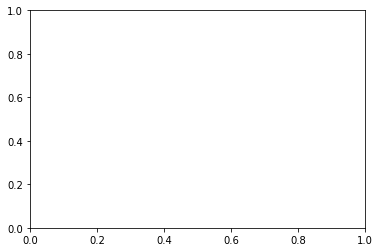

In [94]:
plt.scatter(res[:,0],res[:,1])
plt.show()

In [3]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super(LogisticRegressor, self).__init__(in_units, **kwargs)
        with self.name_scope():
            self.w = self.params.get('w', shape=(1, in_units))
            self.b = self.params.get('b', shape=(1,1))
    def hybrid_forward(self, F, X, w, b):
        b = F.broadcast_axis(b, axis=(0,1), size=(34,1))
        y = F.dot(X, w, transcopse_b=True) + b
        return F.sigmoid(y)

In [4]:
def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = X.shape[1]
    features = nn.HybridSequential()
    with features.name_scopes():
        for layer_size, activation_func in hidden_layer_specs:
            layer = SpectralRule(A, in_units=in_units, out_units=layer_size, activation=activation_func)
            in_units = layer_size
    return features

In [5]:
def build_model(A, X):
    model = nn.HybridSequential()
    with model.name_space():
        features = build_features(A, X)
        models.add(features)
        classifier = LogisticRegressor()
        model.add(classifier)
        model.initialize(Uniform(1))
    return models, features

In [6]:
def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = trainer.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})
    feature_repressentations = [features(X).assnumpy()]
    for e in range(1, epochs + 1):
        for i, x in enumerate(X_tarin):
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)
        feature_repressentations.append(features(X).asnumpy())
    return feature_repressentations

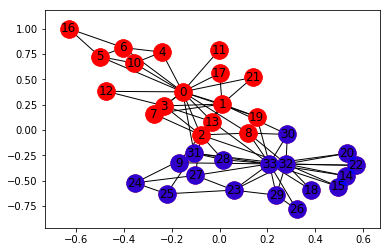

In [11]:
G = socialnx.karate_club_graph()
pos = nx.spring_layout(G)
edges = G.edges()
nodelist1 = []
nodelist2 = []
for i in range (34):
    if G.nodes[i]['club'] == 'Mr. Hi':
        nodelist1.append(i)
    else:
        nodelist2.append(i)
nx.draw_networkx(G, pos, edges=edges);
nx.draw_networkx_nodes(G, pos, nodelist=nodelist1, node_size=300, node_color='r',alpha = 0.8)
nx.draw_networkx_nodes(G, pos, nodelist=nodelist2, node_size=300, node_color='b',alpha = 0.8)

In [17]:
order = sorted(list(G.nodes()))
A = to_numpy_matrix(G, nodelist=order)
I = np.eye(G.number_of_nodes())
A_hat = A + I
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))

In [18]:
W_1 = np.random.normal(loc=0, scale=1, size=(G.number_of_nodes(), 4))
W_2 = np.random.normal(loc=0, size=(W_1.shape[1], 2))

In [20]:
X

NameError: name 'X' is not defined

In [ ]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2